# MethylBoostER - XGBoost for classifying Kidney cancer

To run this training, it takes several days. Would recommend downloading as a .py to run, so you don't need a jupyter notebook being up for days. 

In [69]:
import pandas as pd
import numpy as np

# returns data and labels, ready to be put into a model
# for now, generates dummy data
def get_data():
    # read in diagnoses and get pooled_labels and patient ids
    diagnoses = pd.read_csv('data/training_testing_diagnoses_maxgap_50_newdata.csv', sep = ',')
    
    beta_array = pd.read_csv('data/training_testing_maxgap_50_newdata.csv')
    seqnames = beta_array['seqnames']
    start = beta_array['start']
    colnames = beta_array.columns[2:]
    raw_data = np.array(beta_array.iloc[:, 2:])
    raw_data = np.transpose(raw_data)
                      
    return(raw_data, seqnames, start, colnames, diagnoses)

# getting dummy data: (if you want to test things, this data is very quick to run)
def get_dummy_data():
    # read in diagnoses and get pooled_labels and patient ids
    diagnoses = pd.read_csv('data/training_testing_diagnoses_maxgap_50_newdata.csv', sep = ',')
    
    # create raw data between 0 and 1: (like beta value)
    means = diagnoses.iloc[2:]['overallpath']
    raw_data = [np.random.normal(mean/10, 0.05, 10) for mean in means]
    raw_data = np.abs(raw_data)
    raw_data = np.array([[1 if n > 1 else n for n in r] for r in raw_data])
    
    return(raw_data, diagnoses)

In [70]:
def preproc_diagnoses(diagnoses):
    diagnoses = diagnoses.iloc[2:, ] # remove two redundant rows
    diagnoses.loc[:, 'pooled_labels'] = [4 if d == 5 else d for d in diagnoses['overallpath']] # pool the papilary types
    
    diagnoses.loc[:, 'patient_id'] = list(map(lambda s: s[0], diagnoses['colname'].str.split('.'))) # get before '.' for all samples
    diagnoses.loc[:, 'patient_id'] = np.where(diagnoses['colname'].str.contains('TCGA|R'), np.nan, diagnoses['patient_id']) # filter out TCGA and chopra
    # replace nans with unique ids:
    unique_ids = range(diagnoses['patient_id'].isna().sum()) # in integers
    diagnoses.loc[diagnoses['patient_id'].isna(), 'patient_id'] = unique_ids
    
    labels = np.array(diagnoses['pooled_labels']).astype('int')
    
    # create names for the 5 classes
    class_mapping = {0:'normal', 1:'ccRCC', 2:'chRCC', 3:'onc', 4:'prccT1andT2'}
    classes = [0,1,2,3,4]
    classes = [class_mapping[l] for l in classes]
    
    # and save
    diagnoses[['colname', 'pooled_labels']].to_csv('data/training_testing_maxgap_50_newdata_processed_diagnoses.csv', index = False)
    
    return(diagnoses, labels, classes)

In [71]:
# given m values, removes Inf and -Inf which are caused by a beta value of 1 and 0
def deal_with_Inf(m_values_mat):
    # I will set -Inf to the min value and Inf to the max value
    # I did want to set it to the min and max possible value, but this causes overflow errors
    max_val = np.nanmax(m_values_mat[np.logical_not(np.isinf(m_values_mat))]) # looking at m values that arn't Inf
    min_val = np.nanmin(m_values_mat[np.logical_not(np.isinf(m_values_mat))]) 
    
    print('min and max vals are ', min_val, max_val)
    indices = np.argwhere(np.isinf(m_values_mat)) # where m values is +/- Inf
    for i in range(len(indices)):
        if m_values_mat[indices[i][0], indices[i][1]] > 0:
            m_values_mat[indices[i][0], indices[i][1]] = max_val
        else:
            m_values_mat[indices[i][0], indices[i][1]] = min_val
    return m_values_mat


# turn beta values into m values, deal with infinite values
def preproc_data(data, seqnames, start, colnames):
    # turn into m values
    m_vals = np.log2((data)/(1-data)) # this will result in inf and -infs!
    
    # deal with infinite values
    m_vals = deal_with_Inf(m_vals)
    
    print('mean of data is ', np.nanmean(m_vals))
    
    # now save processed data in nice format
    to_save = pd.DataFrame(np.transpose(m_vals)) # transpose so columns are samples
    to_save.columns = colnames
    to_save.insert(0, 'start', list(start))
    to_save.insert(0, 'seqnames', list(seqnames))
    to_save.to_csv('data/training_testing_maxgap_50_newdata_processed_m_vals.csv')
    
    return(m_vals)
    

In [72]:
# gets train and test arrays and labels
# assumes data is a numpy array
def get_train_test(data, labels, train_indices, test_indices):
    train_x = data[train_indices, :]
    test_x = data[test_indices, :]
    train_y = labels[train_indices]
    test_y = labels[test_indices]
    return(train_x, test_x, train_y, test_y)


In [73]:
# functions to save xgboost evaluation results when training (called in function objective)
import os
def get_evals_result_name():
    nums = set(os.listdir('figs_xgboost/evals_results/')) - set(['.ipynb_checkpoints'])
    if nums == set():
        return('1')
    nums = [int(n) for n in nums]
    name = max(nums) + 1
    return(str(name))

import matplotlib.pyplot as plt
def plot_losses(losses, name):
    train_losses = losses['validation_0']['mlogloss']
    test_losses = losses['validation_1']['mlogloss']
    plt.figure(figsize = (10, 10))
    train_h = plt.scatter(range(len(train_losses)), train_losses, s = 1)
    test_h = plt.scatter(range(len(test_losses)), test_losses, s = 1)
    plt.legend(handles = [train_h, test_h], labels = ['train', 'test'])
    plt.savefig('figs_xgboost/evals_curves/' + name + '_curve.svg')


In [74]:
# I tried 0.1 noise, but it wasn't enough to stop a perfect train score.
def add_noise(data, var = 0.2):
    noise = np.random.normal(0, var, data.shape)
    m_vals_with_noise = data + noise
    return(m_vals_with_noise)

In [75]:
# given some params, does the inner cross validation and returns the mean loss over all folds
import xgboost as xgb
from sklearn.metrics import log_loss, matthews_corrcoef
import pickle
def objective(params, train_x, train_y, inner_folds, train_weights):
    losses = []
    for inner_train_indices, inner_test_indices in inner_folds: # loop through inner folds
        inner_train_x, inner_test_x, inner_train_y, inner_test_y = get_train_test(train_x, train_y, inner_train_indices, inner_test_indices) 
        inner_train_weights = train_weights[inner_train_indices]
        
        # add noise to training data
        inner_train_x = add_noise(inner_train_x)
        
        # train xgboost on inner train
        model = xgb.XGBClassifier(**params, objective = 'binary:logistic', subsample = 0.5, colsample_bytree = 0.5)
        early_stopping_num = 5 # with early stopping
        model.fit(inner_train_x, inner_train_y, sample_weight = inner_train_weights, eval_set=[(inner_train_x, inner_train_y), (inner_test_x, inner_test_y)], eval_metric=['mlogloss'], early_stopping_rounds = early_stopping_num)
        # get eval metrics throughout training of model:
        evals_result = model.evals_result()
        # and save
        name = get_evals_result_name()
        pickle.dump(evals_result, open('figs_xgboost/evals_results/' + name, 'wb'))
        # plot_losses(evals_result, name)
        
        # test model on inner test
        predictions = model.predict(inner_test_x)
        # return scores
        mcc = matthews_corrcoef(inner_test_y, predictions)
        
        losses.append(1-mcc)
        
        # print('fit a model')
    print('Average loss (1-mcc) is ', np.mean(losses), ' for params ', str(params))
    
    return(np.mean(losses))

    

In [76]:
def retrain(params, train_x, train_y, train_weights):
    params['n_estimators'] = int(params['n_estimators']) # need to be cast to int
    params['max_depth'] = int(params['max_depth'])
    
    # add noise to training data
    train_x = add_noise(train_x)
    
    best_model = xgb.XGBClassifier(**params, objective = 'binary:logistic', subsample = 0.5, colsample_bytree = 0.5)
    best_model.fit(train_x, train_y, sample_weight = train_weights)
    return(best_model)

In [77]:
import pickle
import joblib
import os
# take all results from one outer fold, and all storage lists, and put them in the lists 
def append_results(i, best, best_params, bayes_trials, bayes_trials_hist, best_model, best_models, test_indices, test_indices_list):
    best_params.append(best)
    bayes_trials_hist.append(bayes_trials)
    best_models.append(best_model)
    test_indices_list.append(test_indices)
    
    # saving arrays. Will overwrite previous outerfolds so the saved version is always the latest version
    pickle.dump(best_params, open('figs_xgboost/best_params.json', 'wb'))
    pickle.dump(bayes_trials_hist, open('figs_xgboost/bayes_trials_hist.json', 'wb'))
    pickle.dump(test_indices_list, open('figs_xgboost/test_indices_list.json', 'wb'))
    
    # saving latest model - make the dir if necessary and save latest model 
    if not ('xgboost_models') in os.listdir('figs_xgboost/'):
        os.mkdir('figs_xgboost/xgboost_models')
    joblib.dump(best_model, 'figs_xgboost/xgboost_models' + '/' + str(i) + '.pkl')

    
    return(best_params, bayes_trials_hist, best_models, test_indices_list)

    

In [78]:
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from Evaluate import plot_curve
from Evaluate import plot_confusion_matrix

# adds a score object to scores, which contains many metrics. Also saves confusion matrices, and roc and pr curves
def append_scores(i, scores, test_y, test_predictions, test_predictions_prob, classes):
    score_object = {}
    
    score_object['mcc'] = matthews_corrcoef(test_y, test_predictions)
    score_object['acc'] = accuracy_score(test_y, test_predictions)
    score_object['f1'] = f1_score(test_y, test_predictions, average = None)
    score_object['conf_mat'] = confusion_matrix(test_y, test_predictions)
    score_object['precision'] = precision_score(test_y, test_predictions, average = None)
    score_object['recall'] = recall_score(test_y, test_predictions, average = None)
        
    # now plot pr and roc curves and save their areas
    print('classes is ', classes)
    colours = ["#56B4E9", "#007d5b", "#000000", "#D55E00", "#CCBB44"]
    roc_auc = plot_curve('roc', test_y, test_predictions_prob, len(classes), classes, colours, str(i), save_folder = 'figs_xgboost/figs/')
    pr_auc = plot_curve('precision_recall', test_y, test_predictions_prob, len(classes), classes, colours, str(i), save_folder = 'figs_xgboost/figs/')  
    score_object['roc_auc'] = roc_auc
    score_object['pr_auc'] = pr_auc
    
    scores.append(score_object)
    
    # and plotting confusion matrices
    plot_confusion_matrix(confusion_matrix(test_y, test_predictions), 'xgboost_multiclass', save_path = 'figs_xgboost/figs/confusion_matrix_' + str(i) + '.svg', font_size = 36, cm_labels = classes)
    if len(scores) == 4: # if we have done all iterations, save final summed confusion matrix
        conf_mats = [scores[i]['conf_mat'] for i in range(4)]
        plot_confusion_matrix(sum(conf_mats), 'xgboost_multiclass', save_path = 'figs_xgboost/figs/confusion_matrix_sum.svg', font_size = 36, cm_labels = classes)
        
    # now to save the scores
    pickle.dump(scores, open('figs_xgboost/scores.json', 'wb'))
    return(scores)
    

In [79]:
# make xgboost hyperparameter search space
from hyperopt import hp
import numpy as np
from hyperopt.pyll.base import scope
space = { # have restricted the n_estimators and max_depth to 500 and 5 to avoid overfitting
#     'class_weight': hp.choice('class_weight', [None, 'balanced']), # add in weights??
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 1)),
    'eta': hp.loguniform('eta', np.log(0.05), np.log(0.5)),
    'max_depth': scope.int(hp.quniform('max_depth', 2, 3, 1)),
    'reg_alpha': hp.uniform('alpha', 0.0, 1.0), # L1 regularisation
    'reg_lambda': hp.uniform('lambda', 0.0, 1.0), # L2 regularisation
}


In [80]:
# setting it up to work in parallel
# this is set up for jupyter notebook, but it seems to work when running in a python3 script too
import os

# using this guide: https://opensource.com/article/18/11/pyspark-jupyter-notebook
SPARK_HOME = "/home/in268/.local/lib/python3.7/site-packages/pyspark"
os.environ["SPARK_HOME"] = SPARK_HOME
os.environ["PYTHONPATH"]= SPARK_HOME + "/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ['PYSPARK_PYTHON'] = 'python3'
os.environ['PATH'] = SPARK_HOME + ':' + os.environ['PATH'] + ':~/.local/bin:' + os.environ['JAVA_HOME'] + '/bin:' + os.environ['JAVA_HOME'] + '/jre/bin'

from pyspark.sql import SparkSession

# set max memory in spark sess
spark_sess = SparkSession.builder.master('local[2]').config("spark.driver.memory", "60g") .appName('my-cool-app').getOrCreate()


starting to set up


/home/in268/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/in268/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/in268/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

min and max vals are  -12.475986690870657 11.321364432039529
mean of data is  -2.2063126209584643


(1228, 158670)

Should be empty sets if no patient overlaps:
set()
set()
set()
set()


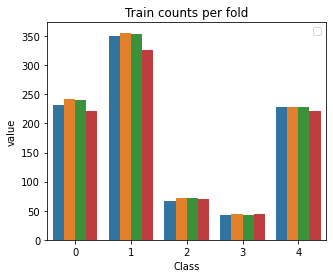

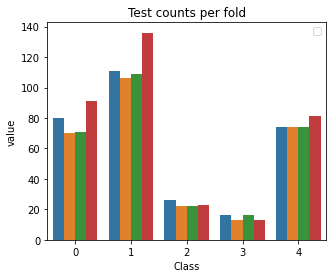

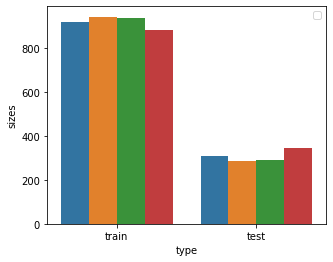

In [81]:
# set up and getting data and outer folds
from hyperopt import tpe, fmin, Trials, SparkTrials
from functools import partial
from get_train_weights import *
from get_folds import *

print('starting to set up')
tpe_algorithm = tpe.suggest # hyperopt optimisation algorithm

best_params = []
bayes_trials_hist = []
best_models = []
test_indices_list = []

scores = []

# if needed, delete history of previous training eval metrics
# to_remove = os.listdir('figs_xgboost/evals_results/')
# for f in to_remove:
#     if f != '.ipynb_checkpoints':
#         os.remove('figs_xgboost/evals_results/' + f)
#         os.remove('figs_xgboost/evals_curves/' + f + '_curve.svg')


# dummy data if you want to quickly test something (and comment out below section)
# data, diagnoses = get_dummy_data()
# diagnoses, labels, classes = preproc_diagnoses(diagnoses)

# get data and preprocess
data, seqnames, start, colnames, diagnoses = get_data()
diagnoses, labels, classes = preproc_diagnoses(diagnoses)
data = preproc_data(data, seqnames, start, colnames)

data.shape

outer_folds = get_folds(diagnoses, 4) # create outer folds
check_folds(diagnoses, outer_folds) # checks folds are created correctly
plot_split_barplots(labels, outer_folds) # plot the number of samples in each class in each fold, to check there is an even distribution between folds

all_test_predictions = np.array([np.nan]*len(labels))

In [84]:
# right do the outer folds have completely unique test sets?
print('Should be 3 empty sets:')
set(outer_folds[0][1]).intersection(outer_folds[1][1])
set(outer_folds[0][1]).intersection(outer_folds[2][1])
set(outer_folds[2][1]).intersection(outer_folds[3][1])


Should be 3 empty sets:


set()

set()

set()

should be 1 number in list:  [1.0875576]
should be 1 number in list:  [1.20833333 1.20833333]
should be 1 number in list:  [1.07575758]
should be 1 number in list:  [1.11904762]
should be 1 number in list:  [1.]
[ True  True  True  True  True]
[ True  True  True  True  True]
True
True
should be 1 number per class:
[array([0.8516129]), array([0.64166667]), array([2.8]), array([4.4, 4.4]), array([0.83243243])]
should be the same number for each class:
               combined_weight
pooled_labels                 
0.0                      184.8
1.0                      184.8
2.0                      184.8
3.0                      184.8
4.0                      184.8
Should be empty sets if no patient overlaps:
set()
set()
set()
set()


/Tank/kidney_methylation_classification/get_train_weights.py:71: RuntimeWarning: Mean of empty slice
  c_1 = np.nanmean([res[0], res[1]], axis = 0)
/Tank/kidney_methylation_classification/get_train_weights.py:72: RuntimeWarning: Mean of empty slice
  c_2 = np.nanmean([c_1, res[2]], axis = 0)
/Tank/kidney_methylation_classification/get_train_weights.py:73: RuntimeWarning: Mean of empty slice
  c_3 = np.nanmean([c_2, res[3]], axis = 0)


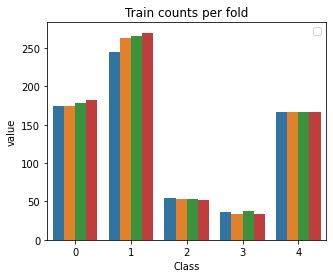

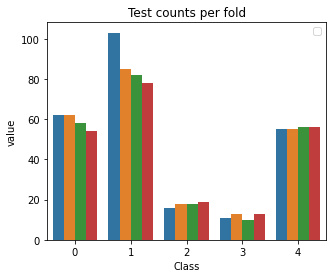

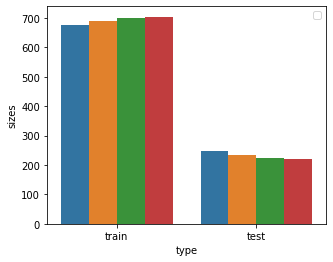

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [15]:
# train and test the models on the data, using nested cross validation and hyperopt for hyperparameter finding
i = 0
for train_indices, test_indices in outer_folds:
    
    train_x, test_x, train_y, test_y = get_train_test(data, labels, train_indices, test_indices)
    diagnoses_train = diagnoses.iloc[train_indices]
    
    # calculate training sample weights
    train_weights = get_weights(diagnoses_train.copy(deep = True))
    check_weights(train_weights) # can comment out if output is annoying
    train_weights = train_weights['combined_weight']
    
    # get inner folds and check them
    inner_folds = get_folds(diagnoses_train, 4)
    check_folds(diagnoses_train, inner_folds) # can comment these two checking functions if the output is annoying
    plot_split_barplots(train_y, inner_folds)

    # hyperopt function, which uses objective function
    bayes_trials_parallel = SparkTrials(parallelism=2, spark_session = spark_sess) 
    bayes_trials = Trials()
    fmin_objective = partial(objective, train_x=train_x, train_y = train_y, inner_folds = inner_folds, train_weights = train_weights) # make parital function with our non-standard arguments
    best = fmin(fn = fmin_objective, space = space, algo = tpe.suggest, 
            max_evals = 10, trials = bayes_trials_parallel)
    
    
    # retrain model over all of x_train with best params
    best_model = retrain(best, train_x, train_y, train_weights)
    
    # save model
    best_params, bayes_trials_hist, best_models, test_indices_list = append_results(i = i, best = best, best_params = best_params, bayes_trials = bayes_trials, bayes_trials_hist = bayes_trials_hist, best_model = best_model, best_models = best_models, test_indices = test_indices, test_indices_list = test_indices_list)
    
    # make predictions 
    test_predictions = best_model.predict(test_x)
    test_predictions_prob = best_model.predict_proba(test_x)
    all_test_predictions[test_indices] = test_predictions
    
    # save scores
    scores = append_scores(i, scores, test_y, test_predictions, test_predictions_prob, classes)
    
    i = i + 1
    


# and finally save all test predictions
np.savetxt(fname =  'figs_xgboost/all_test_predictions', X = all_test_predictions, fmt = "%d")

### Reading in models and results

In [2]:
# reading in models after they have been saved
import pickle
import joblib

def read_models():
        
    models = []
    for i in range(4):
        model = joblib.load('figs_xgboost/xgboost_models/' + str(i) + '.pkl')
        models.append(model)
        
    # now load the other arrays
    test_indices_list = pickle.load(open('figs_xgboost/test_indices_list.json', 'rb'))
    best_params = pickle.load(open('figs_xgboost/best_params.json', 'rb'))
    bayes_trials_hist = pickle.load(open('figs_xgboost/bayes_trials_hist.json', 'rb'))
    
    return(models, test_indices_list, best_params, bayes_trials_hist)


# models, test_indices_list, best_params, bayes_trials_hist = read_models()


In [1]:
# loading scores:
# import pickle
# scores = pickle.load(open('figs_xgboost/scores.json', 'rb'))
# scores

[{'mcc': 0.8974615228431305,
  'acc': 0.9248366013071896,
  'f1': array([0.96052632, 0.93449782, 0.875     , 0.8125    , 0.91390728]),
  'conf_mat': array([[ 73,   0,   0,   0,   0],
         [  3, 107,   0,   0,   6],
         [  1,   1,  21,   0,   1],
         [  2,   1,   2,  13,   1],
         [  0,   4,   1,   0,  69]]),
  'precision': array([0.92405063, 0.94690265, 0.875     , 1.        , 0.8961039 ]),
  'recall': array([1.        , 0.92241379, 0.875     , 0.68421053, 0.93243243]),
  'roc_auc': array([1.        , 0.98557169, 0.99202128, 0.99394829, 0.98724371]),
  'pr_auc': [1.0,
   0.9815486898102758,
   0.9379091214922627,
   0.9287275059369389,
   0.9582200347462837]},
 {'mcc': 0.8794556296793243,
  'acc': 0.9115646258503401,
  'f1': array([0.97368421, 0.91304348, 0.80952381, 0.88888889, 0.87591241]),
  'conf_mat': array([[ 74,   2,   0,   0,   0],
         [  1, 105,   1,   0,   1],
         [  0,   2,  17,   1,   2],
         [  0,   1,   1,  12,   0],
         [  1,  12,  